In [23]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration, AutoProcessor, AutoModelForZeroShotObjectDetection
from PIL import Image
import matplotlib.pyplot as plt
import torch
import json
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import os

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

In [4]:
# Load BLIP2

# Load BLIP-2 processor and model (pretrained on captions)
# Using 2.7B variant of BLIP2 (smallest), can use other variants
input_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
input_model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b").to(device)

dino_processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-tiny")
dino_model = AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-tiny").to(device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]


In [ ]:
coco_dataset = open("data/instances_val2017.json")
coco_json = json.load(coco_dataset)
coco_images = coco_json["images"]
coco_annotations = coco_json["annotations"]
coco_categories = coco_json["categories"]
inputs_url = []
image_url = []

category_validation_images = {}
id_category_mapping = {}

# Get mappings of id number and category name
for category in coco_categories:
    category_validation_images[category["id"]] = []
    id_category_mapping[category["id"]] = category["name"]

# For each category, get all images with that category annotation
for images in coco_images:
    image_inputs = []
    for anno in coco_annotations:
        if anno["image_id"] == images["id"]:
            for categories in coco_categories:
                if anno["category_id"] == categories["id"]:
                    if images not in category_validation_images[anno["category_id"]]:
                        category_validation_images[anno["category_id"]].append(images)

In [47]:
def requests_retry_session(
    retries=100,
    backoff_factor=0.3,
    status_forcelist=(500, 502, 504),
    session=None,
):
    session = session or requests.Session()
    retry = Retry(
        total=retries,
        read=retries,
        connect=retries,
        backoff_factor=backoff_factor,
        status_forcelist=status_forcelist,
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    return session

In [89]:
def plot_results(image, result, category, caption, prompt_image):
    boxes = result["boxes"]
    scores = result["scores"]
    labels = result["labels"]
    fig, axes = plt.subplots(1, 2, figsize = (8, 4))
    plt.axis("off")
    # Plot validation image
    fig.suptitle(f"Category: {category}\nCaption: {caption}")
    axes[0].imshow(image)
    axes[0].set_title("Validation Image")
    axes[0].axis("off")
    colors = plt.cm.hsv(torch.linspace(0, 1, len(boxes))).tolist()
    
    # Add box
    for box, score, label, color in zip(boxes, scores, labels, colors):
        xmin, ymin, xmax, ymax = box.tolist()
        axes[0].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill = False, color = color, linewidth = 2))
        text = f"{label}: {score:.2f}"
        axes[0].text(xmin, ymin, text, bbox = dict(facecolor = "yellow", alpha = 0.5))
    
    # Plot prompt image
    axes[1].imshow(prompt_image)
    axes[1].set_title("Prompt Image")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

/var/folders/6m/288j1hf95f11bm2jzx6bh6d40000gn/T/ipykernel_21053/2790871396.py:34: FutureWarning: `box_threshold` is deprecated and will be removed in version 4.51.0 for `GroundingDinoProcessor.post_process_grounded_object_detection`. Use `threshold` instead.
  results = dino_processor.post_process_grounded_object_detection(
/Users/kevinxu/Library/Python/3.9/lib/python/site-packages/transformers/models/grounding_dino/processing_grounding_dino.py:95: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


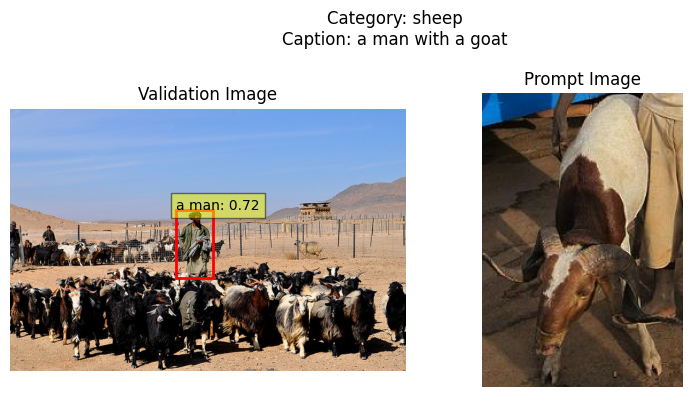

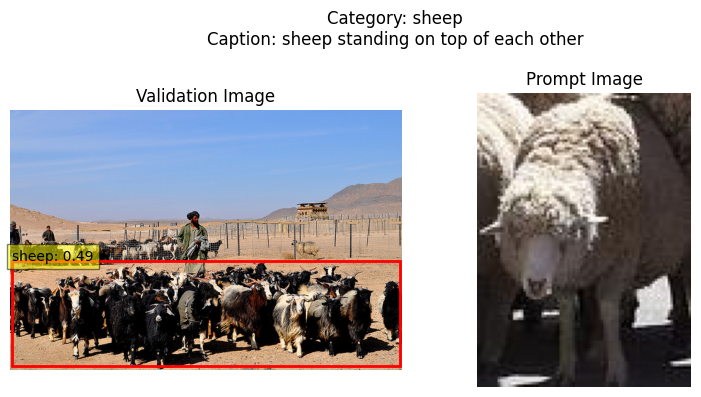

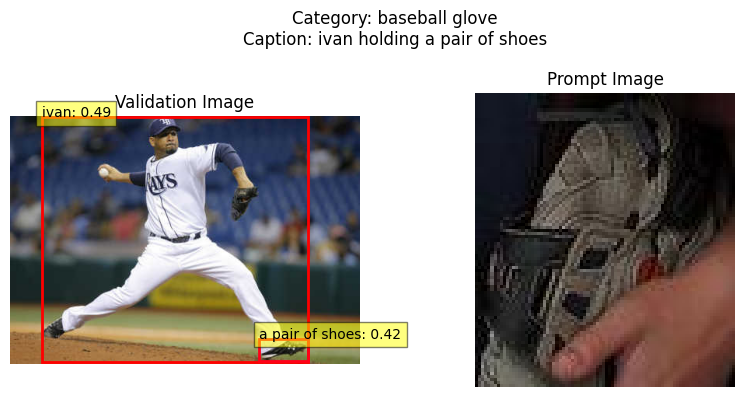

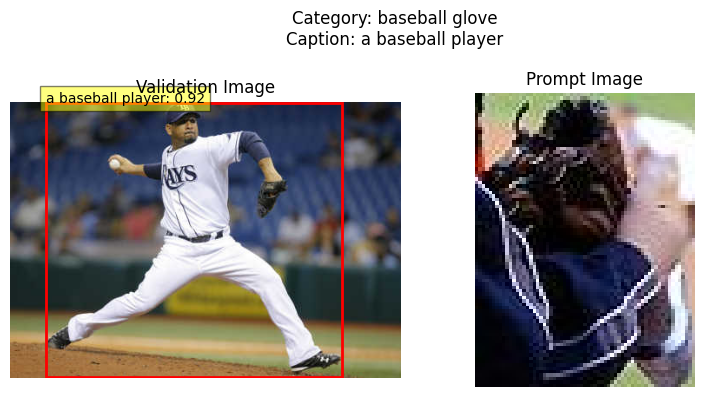

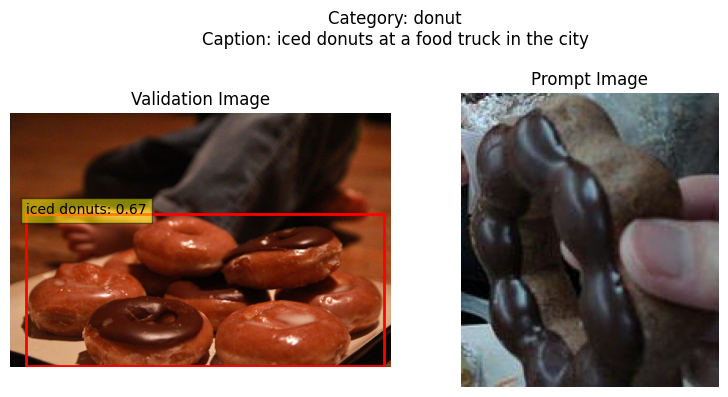

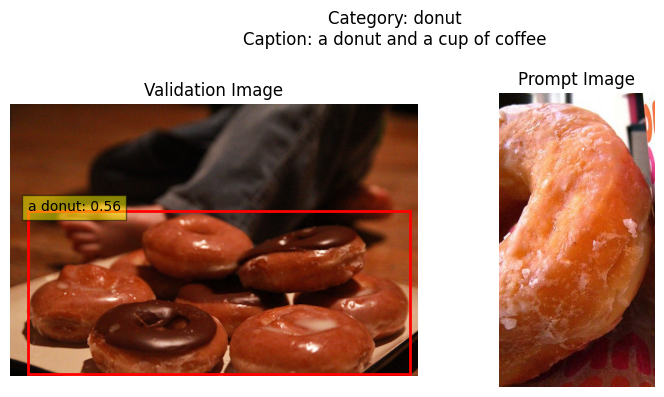

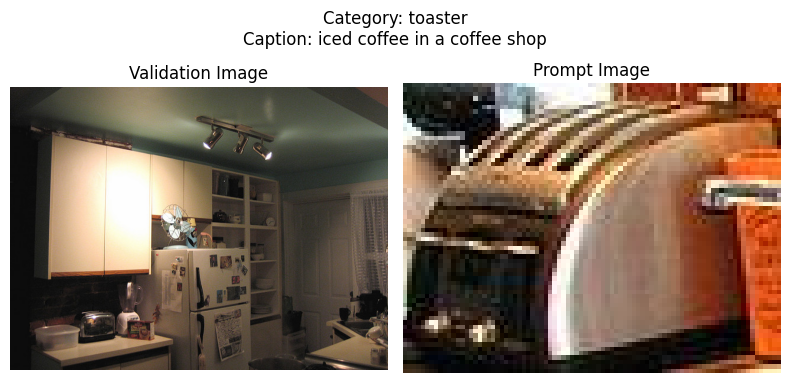

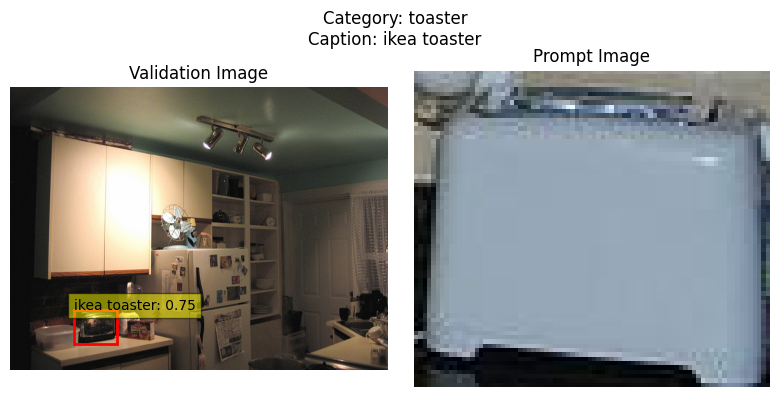

In [90]:
prompt = "This is an image of "

# Number of cropped images in the cateogry to go through
num_cropped_images = 2

# Number of validation images in the category to go through
num_validation_images = 1
category_ids = [20, 40, 60, 80]
# Go through every category
for id in category_ids:
    # All validation images under the category
    images = category_validation_images[id]
    category = id_category_mapping[id]

    # Go thruogh cropped images
    for i in range(num_cropped_images):
        # Open cropped image
        cropped_file = f"./data/cropped_objects/{category}_{i + 1}.jpg"
        prompt_image = Image.open(cropped_file)

        # Generate caption
        inputs = input_processor(images = prompt_image, text = prompt, return_tensors="pt").to(device)
        generated_ids = input_model.generate(**inputs, max_new_tokens=50)
        generated_text = input_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        start = generated_text.find(prompt) + len (prompt)
        generated_caption = generated_text[start:].strip()

        # Go through validation iamges
        for i in range(num_validation_images):
            # Open validation image
            image = Image.open(requests_retry_session().get(images[i]["coco_url"], stream=True).raw)

            # Pass caption and image to grounding dino
            text_labels = [generated_caption]
            inputs = dino_processor(images=image, text=text_labels, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = dino_model(**inputs)
            results = dino_processor.post_process_grounded_object_detection(
                outputs,
                inputs.input_ids,
                box_threshold=0.4,
                text_threshold=0.3,
                target_sizes=[image.size[::-1]]
            )

            # Plot output and prompt image
            plot_results(image, results[0], category, generated_caption, prompt_image)